## 1. Import des Librairies Necessaires

In [12]:
import pandas as pd
import numpy as np
import json
import os
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
import matplotlib.pyplot as plt
import seaborn as sns

print("Toutes les librairies ont été importées avec succès!")

Toutes les librairies ont été importées avec succès!


## 2. Chargement et Exploration des Donnees

In [13]:
# Chemin vers le dataset
data_path = os.path.join('datas', 'flood.csv')
print(f"Chargement du dataset depuis: {data_path}...")

# Chargement du dataset
df = pd.read_csv(data_path)

# Affichage des informations
print(f"\nDimensions du dataset: {df.shape[0]} lignes, {df.shape[1]} colonnes")
print(f"\nAperçu des premières lignes:")
print(df.head())
print(f"\nStatistiques descriptives:")
print(df.describe())

Chargement du dataset depuis: datas\flood.csv...

Dimensions du dataset: 50000 lignes, 21 colonnes

Aperçu des premières lignes:
   MonsoonIntensity  TopographyDrainage  RiverManagement  Deforestation  \
0                 3                   8                6              6   
1                 8                   4                5              7   
2                 3                  10                4              1   
3                 4                   4                2              7   
4                 3                   7                5              2   

   Urbanization  ClimateChange  DamsQuality  Siltation  AgriculturalPractices  \
0             4              4            6          2                      3   
1             7              9            1          5                      5   
2             7              5            4          7                      4   
3             3              4            1          4                      6   
4             5

## 3. Nettoyage et Preparation des Donnees

In [14]:
# Identifier la variable cible et les variables numériques
target_col = "FloodProbability"
num_cols = [c for c in df.select_dtypes(include=[np.number]).columns if c != target_col]

print(f"Variable cible: {target_col}")
print(f"Nombre de features numériques: {len(num_cols)}")
print(f"\nFeatures: {', '.join(num_cols[:5])}... (5 affichées sur {len(num_cols)})")

Variable cible: FloodProbability
Nombre de features numériques: 20

Features: MonsoonIntensity, TopographyDrainage, RiverManagement, Deforestation, Urbanization... (5 affichées sur 20)


In [15]:
# Gestion des outliers avec la méthode IQR (Interquartile Range)
print("Suppression des outliers avec la méthode IQR...\n")

df_clean = df.copy()

outliers_count = {}
for col in num_cols:
    Q1 = df_clean[col].quantile(0.25)
    Q3 = df_clean[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    
    # Compter les outliers avant suppression
    outliers_before = ((df_clean[col] < lower) | (df_clean[col] > upper)).sum()
    outliers_count[col] = outliers_before
    
    # Plafonner les outliers
    df_clean[col] = df_clean[col].clip(lower, upper)

# Affichage des résultats
print(f"Résumé des outliers détectés:")
print(f"- Colonne avec le plus d'outliers: {max(outliers_count, key=outliers_count.get)} ({max(outliers_count.values())} outliers)")
print(f"- Nombre total d'outliers supprimés: {sum(outliers_count.values())}")
print(f"\nNettoyage des données terminé!")

Suppression des outliers avec la méthode IQR...

Résumé des outliers détectés:
- Colonne avec le plus d'outliers: CoastalVulnerability (747 outliers)
- Nombre total d'outliers supprimés: 13728

Nettoyage des données terminé!


## 4. Normalisation (Scaling) des Donnees

In [16]:
# Extraction des features (X) et de la cible (y)
X = df_clean[num_cols].values
y = df_clean[target_col].values

print(f"Shapes des données:")
print(f"- X: {X.shape} (exemples, features)")
print(f"- y: {y.shape}")

# Normalisation globale (pour comparaison ultérieure)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print(f"\nNormalisation StandardScaler appliquée:")
print(f"- Moyenne après scaling: {X_scaled.mean(axis=0).mean():.6f} (≈ 0)")
print(f"- Écart-type après scaling: {X_scaled.std(axis=0).mean():.6f} (≈ 1)")
print(f"\nDonnées prêtes pour la validation croisée!")

Shapes des données:
- X: (50000, 20) (exemples, features)
- y: (50000,)

Normalisation StandardScaler appliquée:
- Moyenne après scaling: 0.000000 (≈ 0)
- Écart-type après scaling: 1.000000 (≈ 1)

Données prêtes pour la validation croisée!


## 5. Configuration de la Validation Croisee K-Fold

In [17]:
# Configuration de K-Fold (5 plis)
kf = KFold(n_splits=5, shuffle=True, random_state=42)

print("Configuration de la Validation Croisée K-Fold:")
print(f"- Nombre de plis (folds): 5")
print(f"- Données mélangées: Oui (shuffle=True)")
print(f"- Random state: 42 (reproductibilité)")
print(f"\nExplication:")
print(f"- Les données seront divisées en 5 parties")
print(f"- Pour chaque pli: 4/5 pour l'entraînement, 1/5 pour le test")
print(f"- Les résultats finaux = moyenne des 5 plis")

# Initialisation du dictionnaire de résultats
results = {
    "Linear Regression": {"mse": [], "r2": []},
    "Random Forest": {"mse": [], "r2": []},
    "Neural Network": {"mse": [], "r2": []}
}

print(f"\nConfiguration terminée!")

Configuration de la Validation Croisée K-Fold:
- Nombre de plis (folds): 5
- Données mélangées: Oui (shuffle=True)
- Random state: 42 (reproductibilité)

Explication:
- Les données seront divisées en 5 parties
- Pour chaque pli: 4/5 pour l'entraînement, 1/5 pour le test
- Les résultats finaux = moyenne des 5 plis

Configuration terminée!


## 6. Boucle de Validation Croisee

### Pour chaque pli, nous allons:
1. Diviser les données en train/test
2. Entraîner les 3 modèles
3. Évaluer chaque modèle
4. Sauvegarder les métriques (MSE et R²)

In [18]:
print("Démarrage de la Validation Croisée...\n")
print("="*70)

for fold, (train_index, test_index) in enumerate(kf.split(X_scaled)):
    print(f"\nPLI {fold+1}/5")
    print("-" * 70)
    
    # Séparation train/test
    X_train, X_test = X_scaled[train_index], X_scaled[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    print(f"Taille train: {X_train.shape[0]} | Taille test: {X_test.shape[0]}")
    
    # ========== MODÈLE 1: RÉGRESSION LINÉAIRE ==========
    print(f"\n1. Régression Linéaire...")
    lr = LinearRegression()
    lr.fit(X_train, y_train)
    y_pred_lr = lr.predict(X_test)
    
    mse_lr = mean_squared_error(y_test, y_pred_lr)
    r2_lr = r2_score(y_test, y_pred_lr)
    results["Linear Regression"]["mse"].append(mse_lr)
    results["Linear Regression"]["r2"].append(r2_lr)
    print(f"MSE: {mse_lr:.6f} | R²: {r2_lr:.4f}")
    
    # ========== MODÈLE 2: FORÊT ALÉATOIRE ==========
    print(f"\n2. Forêt Aléatoire (Random Forest)...")
    rf = RandomForestRegressor(n_estimators=50, random_state=42, n_jobs=-1)
    rf.fit(X_train, y_train)
    y_pred_rf = rf.predict(X_test)
    
    mse_rf = mean_squared_error(y_test, y_pred_rf)
    r2_rf = r2_score(y_test, y_pred_rf)
    results["Random Forest"]["mse"].append(mse_rf)
    results["Random Forest"]["r2"].append(r2_rf)
    print(f"MSE: {mse_rf:.6f} | R²: {r2_rf:.4f}")
    
    # ========== MODÈLE 3: RÉSEAU DE NEURONES ==========
    print(f"\n3. Réseau de Neurones (Deep Learning)...")
    model = Sequential([
        Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
        Dense(32, activation='relu'),
        Dense(1, activation='linear')
    ])
    model.compile(optimizer='adam', loss='mse')
    model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=0, validation_split=0.2)
    y_pred_nn = model.predict(X_test, verbose=0).flatten()
    
    mse_nn = mean_squared_error(y_test, y_pred_nn)
    r2_nn = r2_score(y_test, y_pred_nn)
    results["Neural Network"]["mse"].append(mse_nn)
    results["Neural Network"]["r2"].append(r2_nn)
    print(f"MSE: {mse_nn:.6f} | R²: {r2_nn:.4f}")

print(f"\n" + "="*70)
print("\nValidation Croisée terminée!")

Démarrage de la Validation Croisée...


PLI 1/5
----------------------------------------------------------------------
Taille train: 40000 | Taille test: 10000

1. Régression Linéaire...
MSE: 0.000014 | R²: 0.9943

2. Forêt Aléatoire (Random Forest)...
MSE: 0.000686 | R²: 0.7247

3. Réseau de Neurones (Deep Learning)...


c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


MSE: 0.000019 | R²: 0.9924

PLI 2/5
----------------------------------------------------------------------
Taille train: 40000 | Taille test: 10000

1. Régression Linéaire...
MSE: 0.000013 | R²: 0.9948

2. Forêt Aléatoire (Random Forest)...
MSE: 0.000683 | R²: 0.7316

3. Réseau de Neurones (Deep Learning)...


c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


MSE: 0.000028 | R²: 0.9889

PLI 3/5
----------------------------------------------------------------------
Taille train: 40000 | Taille test: 10000

1. Régression Linéaire...
MSE: 0.000014 | R²: 0.9945

2. Forêt Aléatoire (Random Forest)...
MSE: 0.000681 | R²: 0.7290

3. Réseau de Neurones (Deep Learning)...


c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


MSE: 0.000018 | R²: 0.9928

PLI 4/5
----------------------------------------------------------------------
Taille train: 40000 | Taille test: 10000

1. Régression Linéaire...
MSE: 0.000015 | R²: 0.9941

2. Forêt Aléatoire (Random Forest)...
MSE: 0.000676 | R²: 0.7276

3. Réseau de Neurones (Deep Learning)...


c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


MSE: 0.000028 | R²: 0.9889

PLI 5/5
----------------------------------------------------------------------
Taille train: 40000 | Taille test: 10000

1. Régression Linéaire...
MSE: 0.000013 | R²: 0.9946

2. Forêt Aléatoire (Random Forest)...
MSE: 0.000678 | R²: 0.7272

3. Réseau de Neurones (Deep Learning)...


c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


MSE: 0.000017 | R²: 0.9930


Validation Croisée terminée!


## 7. Calcul des Resultats Finaux

In [19]:
# Calcul des moyennes et écarts-types
final_results = {}
for model_name, metrics in results.items():
    final_results[model_name] = {
        "mean_mse": float(np.mean(metrics["mse"])),
        "std_mse": float(np.std(metrics["mse"])),
        "mean_r2": float(np.mean(metrics["r2"])),
        "std_r2": float(np.std(metrics["r2"]))
    }

print("RESULTATS FINAUX DE LA VALIDATION CROISEE\n")
print("="*80)

for model_name, scores in final_results.items():
    print(f"\n{model_name}:")
    print(f"MSE (Mean Squared Error):")
    print(f"- Moyenne: {scores['mean_mse']:.6f}")
    print(f"- Écart-type: {scores['std_mse']:.6f}")
    print(f"R² Score (Coefficient de Détermination):")
    print(f"- Moyenne: {scores['mean_r2']:.4f}")
    print(f"- Écart-type: {scores['std_r2']:.4f}")

print(f"\n" + "="*80)

RESULTATS FINAUX DE LA VALIDATION CROISEE


Linear Regression:
MSE (Mean Squared Error):
- Moyenne: 0.000014
- Écart-type: 0.000001
R² Score (Coefficient de Détermination):
- Moyenne: 0.9945
- Écart-type: 0.0003

Random Forest:
MSE (Mean Squared Error):
- Moyenne: 0.000681
- Écart-type: 0.000003
R² Score (Coefficient de Détermination):
- Moyenne: 0.7280
- Écart-type: 0.0023

Neural Network:
MSE (Mean Squared Error):
- Moyenne: 0.000022
- Écart-type: 0.000005
R² Score (Coefficient de Détermination):
- Moyenne: 0.9912
- Écart-type: 0.0019



## 8. Visualisation des Resultats

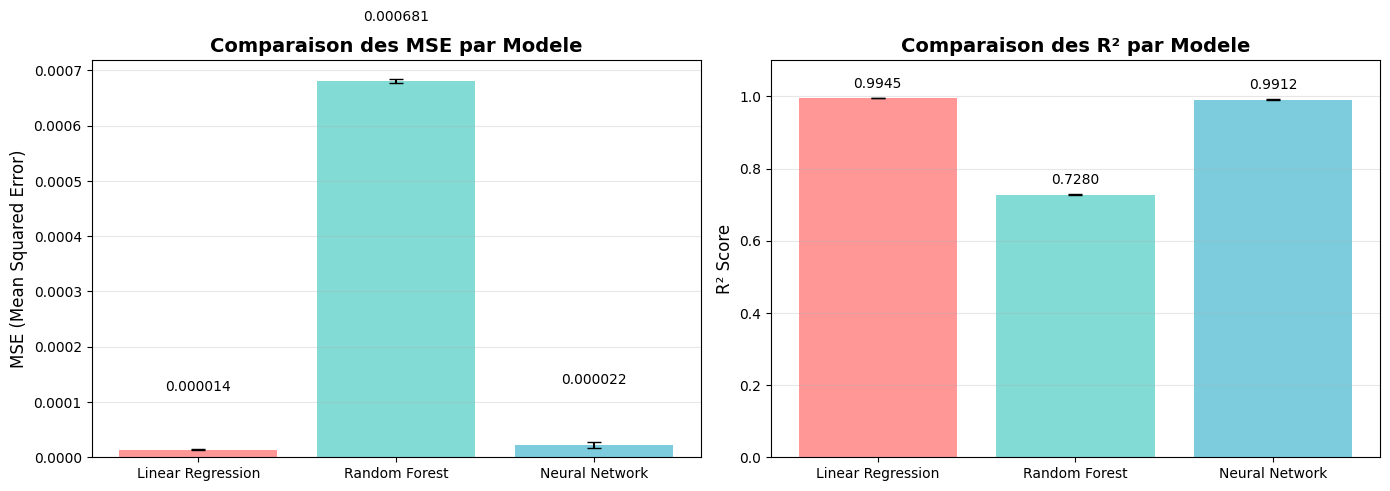


Graphiques de comparaison générés!


In [20]:
# Préparation des données pour la visualisation
models = list(final_results.keys())
mean_mse = [final_results[m]["mean_mse"] for m in models]
std_mse = [final_results[m]["std_mse"] for m in models]
mean_r2 = [final_results[m]["mean_r2"] for m in models]
std_r2 = [final_results[m]["std_r2"] for m in models]

# Création des graphiques
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Graphique 1: MSE
axes[0].bar(models, mean_mse, yerr=std_mse, capsize=5, alpha=0.7, color=['#FF6B6B', '#4ECDC4', '#45B7D1'])
axes[0].set_ylabel('MSE (Mean Squared Error)', fontsize=12)
axes[0].set_title('Comparaison des MSE par Modele', fontsize=14, fontweight='bold')
axes[0].grid(axis='y', alpha=0.3)
for i, v in enumerate(mean_mse):
    axes[0].text(i, v + std_mse[i] + 0.0001, f'{v:.6f}', ha='center', va='bottom')

# Graphique 2: R²
axes[1].bar(models, mean_r2, yerr=std_r2, capsize=5, alpha=0.7, color=['#FF6B6B', '#4ECDC4', '#45B7D1'])
axes[1].set_ylabel('R² Score', fontsize=12)
axes[1].set_title('Comparaison des R² par Modele', fontsize=14, fontweight='bold')
axes[1].set_ylim([0, 1.1])
axes[1].grid(axis='y', alpha=0.3)
for i, v in enumerate(mean_r2):
    axes[1].text(i, v + std_r2[i] + 0.02, f'{v:.4f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

print("\nGraphiques de comparaison générés!")

## 9. Sauvegarde des Resultats

In [21]:
# Sauvegarde en JSON
with open('cv_results.json', 'w') as f:
    json.dump(final_results, f, indent=4)

print("Résultats sauvegardés dans: cv_results.json")
print(f"\nContenu du fichier JSON:")
print(json.dumps(final_results, indent=4))

Résultats sauvegardés dans: cv_results.json

Contenu du fichier JSON:
{
    "Linear Regression": {
        "mean_mse": 1.3852919958247851e-05,
        "std_mse": 5.421390220730393e-07,
        "mean_r2": 0.9944640288119821,
        "std_r2": 0.0002537680757863837
    },
    "Random Forest": {
        "mean_mse": 0.000680815768,
        "std_mse": 3.4288331649378295e-06,
        "mean_r2": 0.7280020755935777,
        "std_r2": 0.0022706805968128116
    },
    "Neural Network": {
        "mean_mse": 2.2059336762943398e-05,
        "std_mse": 4.8546299983557604e-06,
        "mean_r2": 0.9911939140000399,
        "std_r2": 0.0019050524697786751
    }
}


## 10. Conclusion et Recommandations

In [22]:
# Déterminer le meilleur modèle selon le MSE
best_model_mse = min(final_results.items(), key=lambda x: x[1]["mean_mse"])
best_model_r2 = max(final_results.items(), key=lambda x: x[1]["mean_r2"])

print("CONCLUSIONS\n")
print("="*80)
print(f"\nMeilleur modèle (MSE): {best_model_mse[0]}")
print(f"MSE: {best_model_mse[1]['mean_mse']:.6f}")
print(f"R²: {best_model_mse[1]['mean_r2']:.4f}")

print(f"\nMeilleur modèle (R²): {best_model_r2[0]}")
print(f"MSE: {best_model_r2[1]['mean_mse']:.6f}")
print(f"R²: {best_model_r2[1]['mean_r2']:.4f}")

print(f"\nRésumé des Performances:")
for model_name, scores in final_results.items():
    improvement_mse = ((final_results["Linear Regression"]["mean_mse"] - scores["mean_mse"]) / final_results["Linear Regression"]["mean_mse"] * 100)
    print(f"\n{model_name}:")
    print(f"- Amélioration par rapport à Régression Linéaire: {improvement_mse:+.1f}%")
    print(f"- Stabilité (std MSE): {scores['std_mse']:.6f} (inférieur = plus stable)")

print(f"\n" + "="*80)
print(f"\nValidation Croisée terminée avec succès!")

CONCLUSIONS


Meilleur modèle (MSE): Linear Regression
MSE: 0.000014
R²: 0.9945

Meilleur modèle (R²): Linear Regression
MSE: 0.000014
R²: 0.9945

Résumé des Performances:

Linear Regression:
- Amélioration par rapport à Régression Linéaire: +0.0%
- Stabilité (std MSE): 0.000001 (inférieur = plus stable)

Random Forest:
- Amélioration par rapport à Régression Linéaire: -4814.6%
- Stabilité (std MSE): 0.000003 (inférieur = plus stable)

Neural Network:
- Amélioration par rapport à Régression Linéaire: -59.2%
- Stabilité (std MSE): 0.000005 (inférieur = plus stable)


Validation Croisée terminée avec succès!
